In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import matplotlib.pyplot as plt

In [21]:
# Load the data (assuming the same Excel file structure as before)
df = pd.read_excel('../../data-collection/NCES_data/cleaned_1970-2022.xlsx', header=3, usecols=[0, 2], names=['Year', 'Faculty'])

df = df.dropna()
df = df.drop(0)


df['Year'] = df['Year'].astype(int)
df['Faculty'] = df['Faculty'].astype(int)

# Convert 'Year' to datetime and set it as the index
df.set_index('Year', inplace=True)

# Ensure the index is datetime and sorted
df.index = pd.to_datetime(df.index, format='%Y')
df = df.sort_index()
df = df.resample('Y').mean()
df['Faculty'] = df['Faculty'].interpolate(method='linear', limit_direction='both')

# print(df)

C:\Users\sadit\AppData\Local\Temp\ipykernel_49568\3357088657.py:17: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df = df.resample('Y').mean()


In [11]:
# Simple Moving Average (SMA)
window_size = 5  # You can adjust this
df['SMA'] = df['Faculty'].rolling(window=window_size, center=False).mean()
sma_forecast = df['SMA'].iloc[-1]  # Use the last SMA value as the forecast

# Exponential Smoothing with fixed parameters
model_es = ExponentialSmoothing(df['Faculty'], trend='add', seasonal=None)
fit_es = model_es.fit(smoothing_level=0.3, smoothing_trend=0.1)  # Fixed parameters
es_forecast = fit_es.forecast(steps=2)  # Forecast for 2023 and 2024

# Improved ARIMA
# First, let's use auto_arima to find the best parameters
auto_model = auto_arima(df['Faculty'], start_p=0, start_q=0, max_p=5, max_q=5, m=1,
                        d=None, trace=True, error_action='ignore', suppress_warnings=True, 
                        stepwise=True)

# Now use the best parameters found by auto_arima
best_order = auto_model.order
model_arima = ARIMA(df['Faculty'], order=best_order)
fit_arima = model_arima.fit()
arima_forecast = fit_arima.forecast(steps=2)  # Forecast for 2023 and 2024


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1119.153, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1121.159, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1121.233, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1144.377, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1123.149, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.120 seconds


In [12]:
# Print results
print("Simple Moving Average forecast for 2024:", round(sma_forecast))
print("Exponential Smoothing forecast for 2024:", round(es_forecast.iloc[-1]))
print("ARIMA forecast for 2024:", round(arima_forecast.iloc[-1]))

Simple Moving Average forecast for 2024: 838403
Exponential Smoothing forecast for 2024: 878773
ARIMA forecast for 2024: 842407


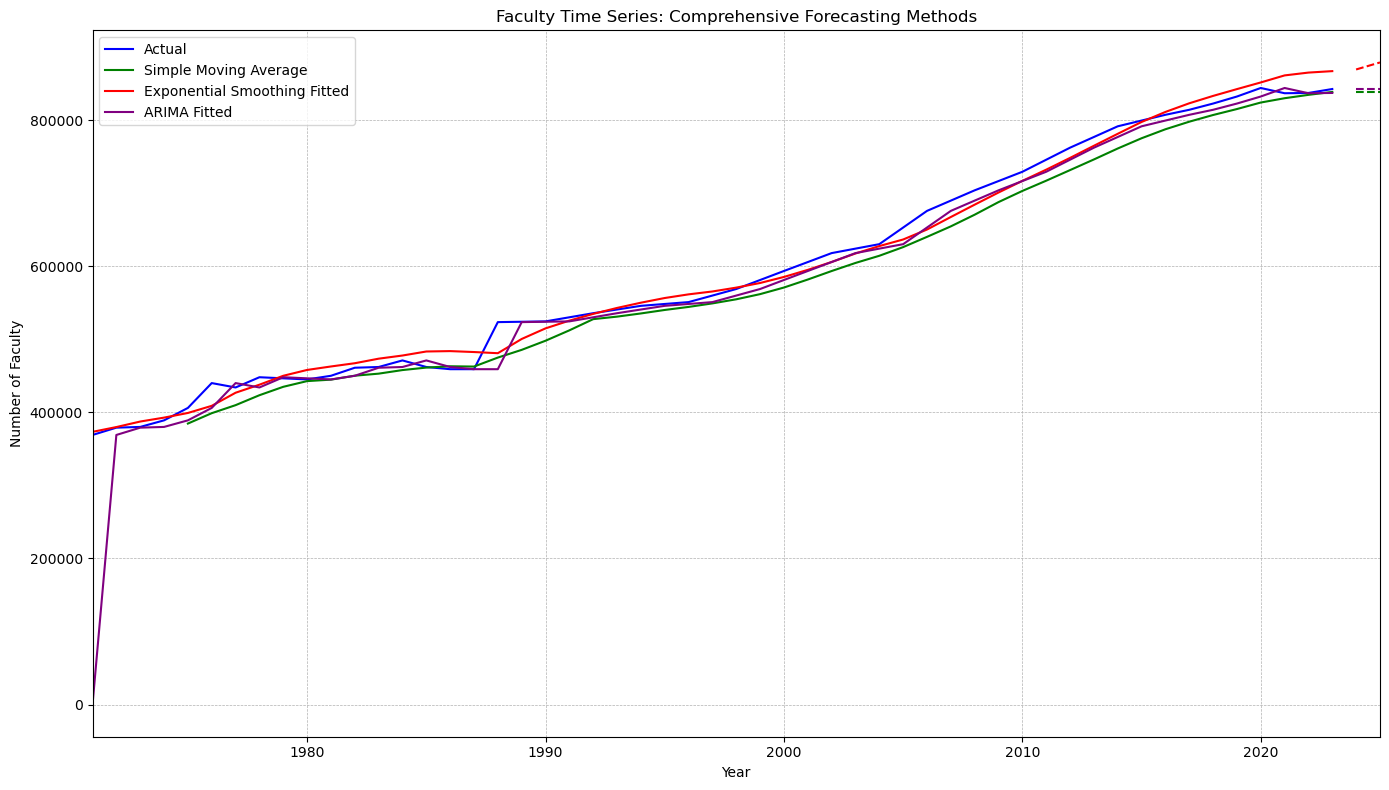

In [20]:
# Visualize the results
plt.figure(figsize=(14, 8))

# Plot actual data
plt.plot(df.index, df['Faculty'], label='Actual', color='blue')

# Plot SMA
plt.plot(df.index, df['SMA'], label='Simple Moving Average', color='green')
plt.plot(es_forecast.index, np.array([sma_forecast, sma_forecast]), color='green', linestyle='--')

# Plot Exponential Smoothing forecast
plt.plot(df.index, fit_es.fittedvalues, label='Exponential Smoothing Fitted', color='red')
plt.plot(es_forecast.index, es_forecast, color='red', linestyle='--')

# Plot ARIMA forecast
plt.plot(df.index, fit_arima.fittedvalues, label='ARIMA Fitted', color='purple')
plt.plot(arima_forecast.index, arima_forecast, color='purple', linestyle='--')

# Extend x-axis to include forecast years
plt.xlim(df.index.min(), arima_forecast.index.max())

plt.legend()
plt.title('Faculty Time Series: Comprehensive Forecasting Methods')
plt.xlabel('Year')
plt.ylabel('Number of Faculty')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()